# Distribution des continents dans le temps 

Dans ce carnet est proposée une analyse de la distribution dans le temps des continents relatifs aux pays d'appartenance, en relation aux années de naissance de la population retenue.


In [8]:
### Librairie à installer dans l'environnement conda (si on exécute en local)
# qui sera choisi pour exécuter le carnet
from SPARQLWrapper import SPARQLWrapper, JSON, TURTLE, XML, RDFXML
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np

In [9]:
### Librairies déjà installées avec Python
import pprint
import csv
import sys
from importlib import reload
import sqlite3 as sql

import time
import datetime
from dateutil import parser


from shutil import copyfile


In [10]:
### Importer un module de fonctions crées ad hoc
##  ATTENTION : le fichier 'sparql_functions.py' doit se trouver 
#   dans un dossier qui se situe dans le chemin ('path') de recherche
#   vu par le présent carnet Jupyter afin que
#   l'importation fonctionne correctement

# Add parent directory to the path
sys.path.insert(0, '..')

### If you want to add the parent-parent directory,
sys.path.insert(0, '../..')


import sparql_functions as spqf

## SPARQL Query qui récupère les données

On exécute la requête grâce à une fonction de la librairie locale qui réalise la mise en forme

In [11]:
## define SPARQL enpoint
endpoint = "https://ag13s8z3wvmae0kr.allegrograph.cloud/repositories/rappers"

In [12]:
query = """
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>


SELECT  ?s (MAX(?label) as ?label) (xsd:integer(MAX(?birthDate)) as ?birthDate) 
            (MAX(?gen) as ?gen) ( GROUP_CONCAT(?continentLabel; separator=", ") AS ?onctinents )
WHERE {
    GRAPH <https://github.com/Ziedellouzi/rappers/blob/main/graphs/wikidata-imported-data.md>
        {?s wdt:P21 ?gen;
            rdfs:label ?label;
            wdt:P569 ?birthDate;
            wdt:P27 ?country.
        ?country wdt:P30 ?continent.
        ?continent rdfs:label ?continentLabel.
        ## Excluding Eurasia, Australia and Oceania insular
        FILTER ( ?continent NOT IN (wd:Q538, wd:Q3960, wd:Q5401))
          }
}
GROUP BY ?s
"""

In [13]:
### Executer la requête avec les fonctions de la librairie locale
qr = spqf.get_json_sparql_result(endpoint,query)

In [14]:
r = [l for l in spqf.sparql_result_to_list(qr)]
print(len(r))
r[:3]

7829


[['http://www.wikidata.org/entity/Q89493281',
  'Jimmy Prime',
  '1993',
  'http://www.wikidata.org/entity/Q6581097',
  'North America'],
 ['http://www.wikidata.org/entity/Q4993086',
  'Kreva',
  '1976',
  'http://www.wikidata.org/entity/Q6581097',
  'Asia'],
 ['http://www.wikidata.org/entity/Q23664291',
  'Ko-Jo Cue',
  '1989',
  'http://www.wikidata.org/entity/Q6581097',
  'Africa']]

In [15]:
### Créer un DataFrame à partir du résultat
df_p = pd.DataFrame(r)
df_p.columns = ['personUri', 'personLabel', 'birthYear', 'genderUri', 'continents']
df_p.head()

,personUri,personLabel,birthYear,genderUri,continents
0,http://www.wikidata.org/entity/Q89493281,Jimmy Prime,1993,http://www.wikidata.org/entity/Q6581097,North America
1,http://www.wikidata.org/entity/Q4993086,Kreva,1976,http://www.wikidata.org/entity/Q6581097,Asia
2,http://www.wikidata.org/entity/Q23664291,Ko-Jo Cue,1989,http://www.wikidata.org/entity/Q6581097,Africa
3,http://www.wikidata.org/entity/Q28498299,Tommy Cash,1991,http://www.wikidata.org/entity/Q6581097,Europe
4,http://www.wikidata.org/entity/Q5026891,Camoflauge,1981,http://www.wikidata.org/entity/Q6581097,North America


In [16]:
df_p.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7829 entries, 0 to 7828
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   personUri    7829 non-null   object
 1   personLabel  7829 non-null   object
 2   birthYear    7829 non-null   object
 3   genderUri    7829 non-null   object
 4   continents   7829 non-null   object
dtypes: object(5)
memory usage: 305.9+ KB


## Coder les continents et afficher leur distribution

In [17]:
def codeContinents(continents):
    listContinents = sorted(continents.split(','))
    if 'Europe' in listContinents:
        output = 'Europe'
    elif 'Asia' in listContinents:
        output = 'Asia'
    elif 'Africa' in listContinents:
        output = 'Africa'
    elif 'Oceania' in listContinents:
        output = 'Oceania'   
    elif 'North America' in listContinents:
        output = 'NorthAmerica'   
    elif 'South America' in listContinents:
        output = 'SouthAmerica' 
    else:
        output = 'Missing'                 
    return output    

In [18]:
codeContinents('Oceania, North America, Africa')

'Oceania'

In [19]:
### On ajoute une nouvelle colonne et y on met pour chaque ligne le résultat de la fonction
df_p['contCode'] = df_p.apply(lambda x: codeContinents(x['continents']), axis=1)
df_p.head(3)

,personUri,personLabel,birthYear,genderUri,continents,contCode
0,http://www.wikidata.org/entity/Q89493281,Jimmy Prime,1993,http://www.wikidata.org/entity/Q6581097,North America,NorthAmerica
1,http://www.wikidata.org/entity/Q4993086,Kreva,1976,http://www.wikidata.org/entity/Q6581097,Asia,Asia
2,http://www.wikidata.org/entity/Q23664291,Ko-Jo Cue,1989,http://www.wikidata.org/entity/Q6581097,Africa,Africa


In [20]:
df_p.iloc[ 115:120 :  ]

,personUri,personLabel,birthYear,genderUri,continents,contCode
115,http://www.wikidata.org/entity/Q16221472,Nickelz,1982,http://www.wikidata.org/entity/Q6581097,North America,NorthAmerica
116,http://www.wikidata.org/entity/Q126927,Mase,1975,http://www.wikidata.org/entity/Q6581097,North America,NorthAmerica
117,http://www.wikidata.org/entity/Q104860456,S-Pion,1991,http://www.wikidata.org/entity/Q6581097,Europe,Europe
118,http://www.wikidata.org/entity/Q44627488,Supa Bwe,1989,http://www.wikidata.org/entity/Q6581097,North America,NorthAmerica
119,http://www.wikidata.org/entity/Q3950893,Saukrates,1978,http://www.wikidata.org/entity/Q6581097,North America,NorthAmerica


In [21]:


### Regrouper et compter
df_contCode = df_p.groupby('contCode').size()
df_contCode = pd.DataFrame(df_contCode.sort_values(ascending = True))
#df_contCode.reset_index(inplace=True)
df_contCode.columns=['effectif']
print(df_contCode)



              effectif
contCode              
Oceania             47
SouthAmerica       222
Africa             520
Asia               803
Europe            2989
NorthAmerica      3248


In [22]:


df_contCode['frequence'] = (100 * df_contCode['effectif'] \
                                   / df_contCode['effectif'].sum()).round(2)
df_contCode



,effectif,frequence
contCode,,
Oceania,47,0.60
SouthAmerica,222,2.84
Africa,520,6.64
Asia,803,10.26
Europe,2989,38.18
NorthAmerica,3248,41.49


In [23]:

ljt = pd.DataFrame(df_contCode['frequence'].sort_values(ascending=False)).T
ljt



contCode,NorthAmerica,Europe,Asia,Africa,SouthAmerica,Oceania
frequence,41.49,38.18,10.26,6.64,2.84,0.6


In [24]:
### Définir les couleurs en fonction des continents
# Noter que cette liste des couleurs et continents
# doit être adaptée à l'ordre de tri des données 
# dans le graphique
col_palette = [
    "#DCDCDC",  # Gainsboro : Europe
    "#cd5c5c",  # Indian Red : NorthAmerica
    "#F4A261",  # Light Coral: Asia
    "#F6E58D",  # Light Yellow :SouthAmerica
    "#B2E0B2",  # Light Green : Oceania
    "#A3C1DA",  # Light Blue : Africa    

]


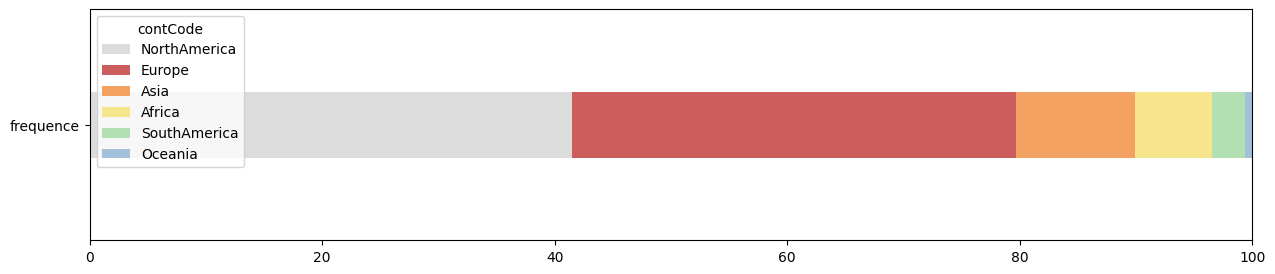

In [25]:


### Pandas plot reference
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.html
## Barplots
# https://www.shanelynn.ie/bar-plots-in-python-using-pandas-dataframes/

fig = ljt.plot(kind='barh', stacked=True, figsize=(15,3), color=col_palette, width=0.2, xlim=[0,100])

### Codage par période de vingt-cinq ans

In [26]:
### Créer une liste d'années pour séparer en périodes de 25 ans
# noter que la dernière année sera exclue, 
# elle donc doit être supérieure à la valeur maximale 
l_25 = list(range(1751, 2025, 25))
print(l_25[:5],l_25[-5:], len(l_25)-1)

[1751, 1776, 1801, 1826, 1851] [1901, 1926, 1951, 1976, 2001] 10


In [27]:
### Transformer les années de naissance en entiers
df_p.birthYear = df_p.birthYear.apply(lambda x : int(x))

In [21]:
### fonction pd.cut : https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html
# On ajoute une nouvelle colonne qui contient la période sur la base de la liste précédente
# et de la valeur de l'année

df_p['per_25'] = pd.cut(df_p['birthYear'], l_25, right=False)

### Transformer le code ajouté pour qu'il soit plus lisible
# noter qu'on a arrondi les valeurs
df_p['per_25'] = df_p['per_25'].apply(lambda x : str(int(x.left))+'-'+ str(int(x.right)-1))

# Inspection
df_p.head(3)

,personUri,personLabel,birthYear,genderUri,continents,contCode,per_25
0,http://www.wikidata.org/entity/Q97193482,Q97193482,1941,http://www.wikidata.org/entity/Q6581097,"Asia, Europe, Europe",Asia,1926-1950
1,http://www.wikidata.org/entity/Q4511380,Anita Goel,1973,http://www.wikidata.org/entity/Q6581072,"Asia, North America",Asia,1951-1975
2,http://www.wikidata.org/entity/Q4706857,Alan Herries Wilson,1906,http://www.wikidata.org/entity/Q6581097,Europe,Europe,1901-1925


In [34]:
print(df_p.columns)


Index(['personUri', 'personLabel', 'birthYear', 'genderUri', 'continents',
       'contCode'],
      dtype='object')


In [35]:
# Assure-toi que la colonne 'birthDate' existe et est de type numérique
df_p['birthYear'] = pd.to_numeric(df_p['birthYear'], errors='coerce')

# Créer la colonne 'per_25' (groupement par tranches de 25 ans)
df_p['per_25'] = (df_p['birthYear'] // 25 * 25).astype('Int64')

# Regrouper par période
naissances_per = df_p.groupby('per_25').size()

# Afficher
print(naissances_per)


per_25
1875       2
1900     371
1925       8
1950    1028
1975    5669
2000     751
dtype: int64


In [36]:
### distribution des naissances par périodes de 25 ans
naissances_per = df_p.groupby(by='per_25').size()
print(naissances_per)

per_25
1875       2
1900     371
1925       8
1950    1028
1975    5669
2000     751
dtype: int64


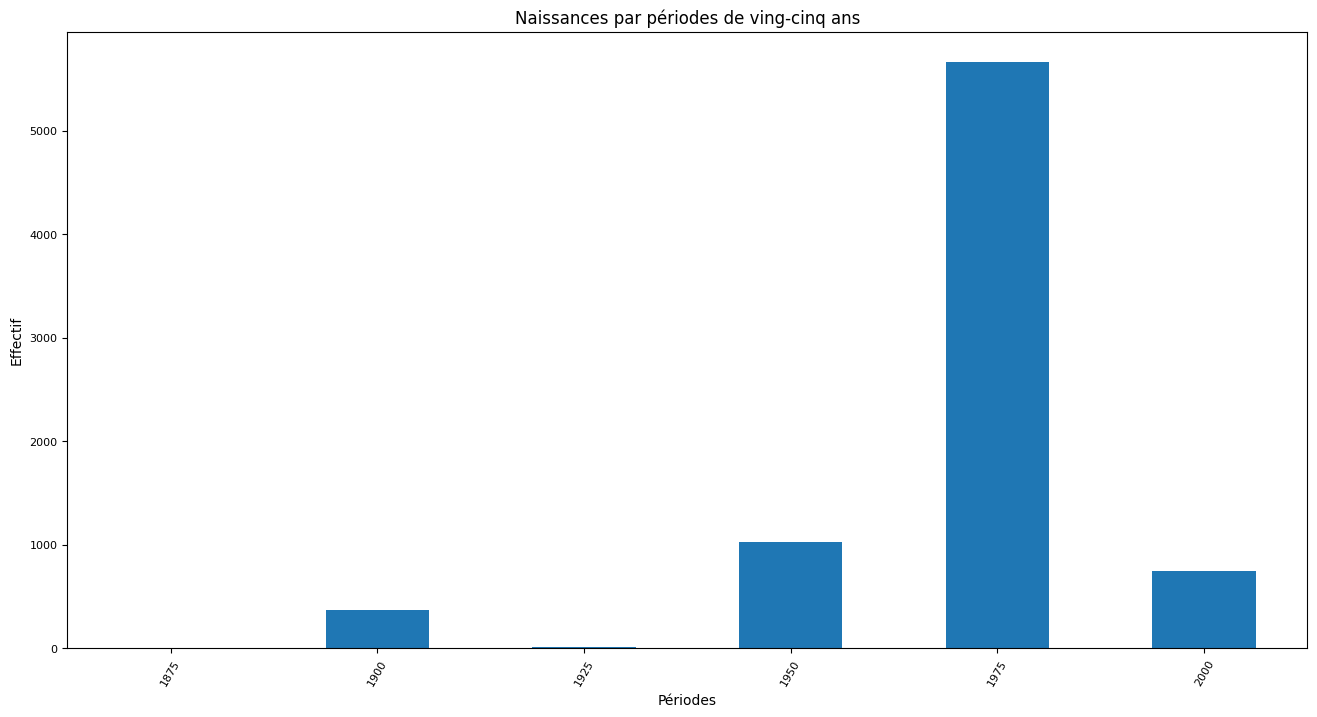

In [37]:
### Diagramme à barres représentant la distribution par 'génération'
ax = df_p.groupby(by='per_25').size().plot(kind='bar',rot=60, fontsize=8, figsize=(16,8))
plt.ylabel('Effectif')
plt.xlabel('Périodes')
plt.title('Naissances par périodes de ving-cinq ans')
plt.show()

## Ajouter la représentation des continents

In [38]:
lcont = list(sorted(set(df_p.contCode.to_list())))
lcont.remove('Europe')
print(lcont)

['Africa', 'Asia', 'NorthAmerica', 'Oceania', 'SouthAmerica']


In [39]:
### Regrouper et compter avec un fitre sur le continent 'Europe'
merged = pd.DataFrame(df_p[df_p.contCode == 'Europe'].groupby('per_25').size())
merged.columns = ['Europe']
merged.tail()



,Europe
per_25,
1900,88
1925,2
1950,267
1975,2344
2000,286


In [40]:
### Ajouter les distributions des autres continents
for cont in lcont:
    new_df = pd.DataFrame(df_p[df_p.contCode == cont].groupby('per_25').size())
    new_df.columns = [cont]
    merged = pd.merge(merged, new_df, left_index=True, right_index=True)

merged    
    

,Europe,Africa,Asia,NorthAmerica,Oceania,SouthAmerica
per_25,,,,,,
1900,88,13,10,246,5,9
1950,267,28,36,674,2,21
1975,2344,445,639,2055,34,152
2000,286,34,118,267,6,40


In [41]:
### Transformer l'index en chaîne de caractères
# ce qui est indispensable pour l'affichage dans un graphique
merged.index = merged.index.map(str)
merged

,Europe,Africa,Asia,NorthAmerica,Oceania,SouthAmerica
per_25,,,,,,
1900,88,13,10,246,5,9
1950,267,28,36,674,2,21
1975,2344,445,639,2055,34,152
2000,286,34,118,267,6,40


In [42]:
### Adapter à l'ordre des colonnes
col_palette_1 = [
    "#DCDCDC",  # Gainsboro : Europe
    "#A3C1DA",  # Light Blue : Africa
    "#F4A261",  # Light Coral : Asia
    "#cd5c5c",  # Indian Red : NorthAmerica
    "#B2E0B2",  # Light Green : Oceania
    "#F6E58D",  # Light Yellow : SouthAmerica
    
]


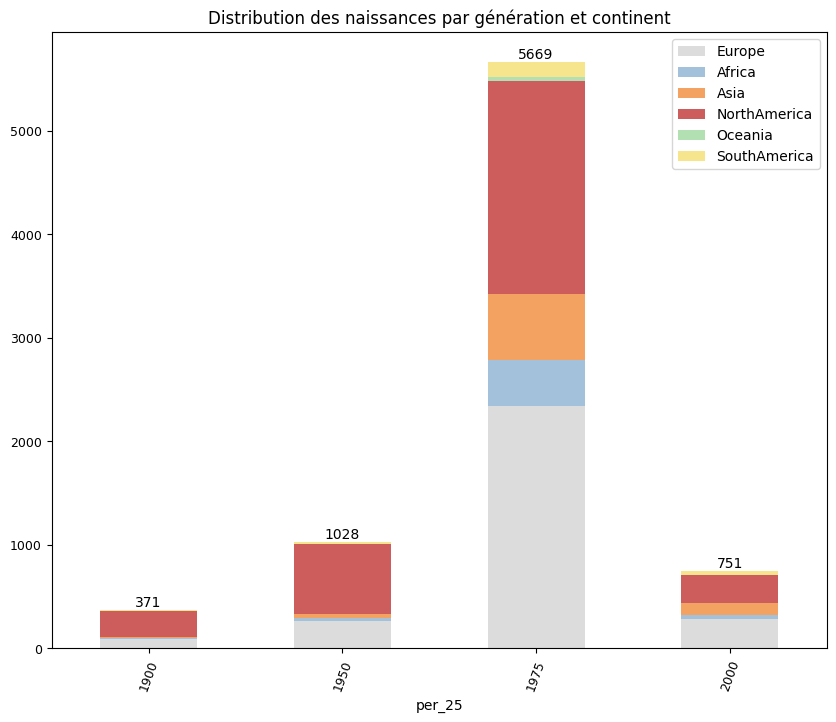

In [43]:
### Représenter l'évolution de la distribution dans le temps par continent
#  Documentation
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.bar.html

data = merged

ax = data.plot.bar(stacked=True, rot=70, fontsize=9, figsize=(10,8), 
                     color=col_palette_1)
plt.title('Distribution des naissances par génération et continent')

## https://stackoverflow.com/questions/71320380/add-only-the-total-values-on-top-of-stacked-bars
ax.bar_label(ax.containers[-1])

plt.show()

## Représentation des mêmes informations avec une graphique décomposé




In [44]:
## L'information à représenter (la distribution des effectifs)
merged

,Europe,Africa,Asia,NorthAmerica,Oceania,SouthAmerica
per_25,,,,,,
1900,88,13,10,246,5,9
1950,267,28,36,674,2,21
1975,2344,445,639,2055,34,152
2000,286,34,118,267,6,40


In [45]:
### Fréquences par période
merged_prop = merged.apply(lambda x: (x / x.sum()) * 100, axis=1).round(1)
merged_prop

,Europe,Africa,Asia,NorthAmerica,Oceania,SouthAmerica
per_25,,,,,,
1900,23.7,3.5,2.7,66.3,1.3,2.4
1950,26.0,2.7,3.5,65.6,0.2,2.0
1975,41.3,7.8,11.3,36.2,0.6,2.7
2000,38.1,4.5,15.7,35.6,0.8,5.3


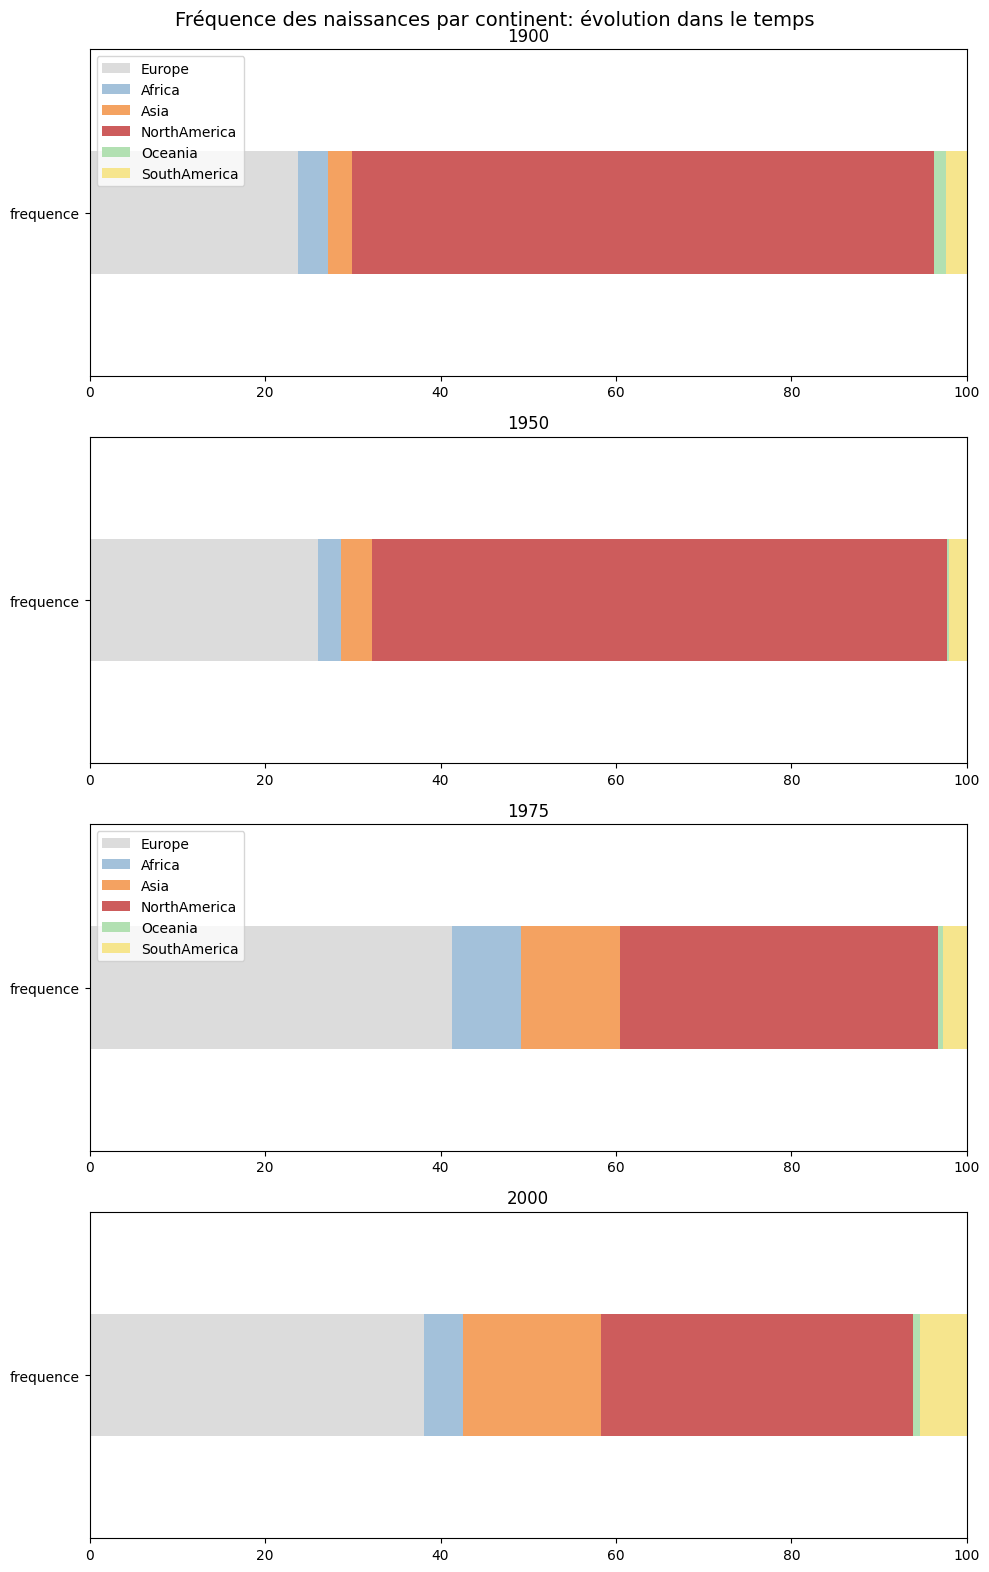

In [46]:
### Graphique multiple
#  Pandas plot reference
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.html
## Barplots
# https://www.shanelynn.ie/bar-plots-in-python-using-pandas-dataframes/


lm = len(merged)

# Initialise the subplot function using number of rows and columns
#figure, axis = plt.subplots(lm, 1)

fig, axes = plt.subplots(lm, 1, figsize=(10,16))

i = 0

while i < lm:
    df = pd.DataFrame(merged.iloc[i , ])
    df['frequence'] = (100 * df / df.sum()).round(2)
    ljt = pd.DataFrame(df['frequence']).T
    # print(ljt)
    fig = ljt.plot(kind='barh', stacked=True, ax=axes[i], label=None, xlabel=None, 
                   fontsize=10, color=col_palette_1, width=0.3, xlim=[0,100])
    fig.set_title(df.columns[0])
    if (i+2)%2 != 0:
        fig.get_legend().remove()
    i += 1
    

plt.suptitle('Fréquence des naissances par continent: évolution dans le temps',  fontsize=14)
             
plt.tight_layout()  # rect=[0, 0.03, 1, 0.90]
plt.xlabel('')

   
plt.show()




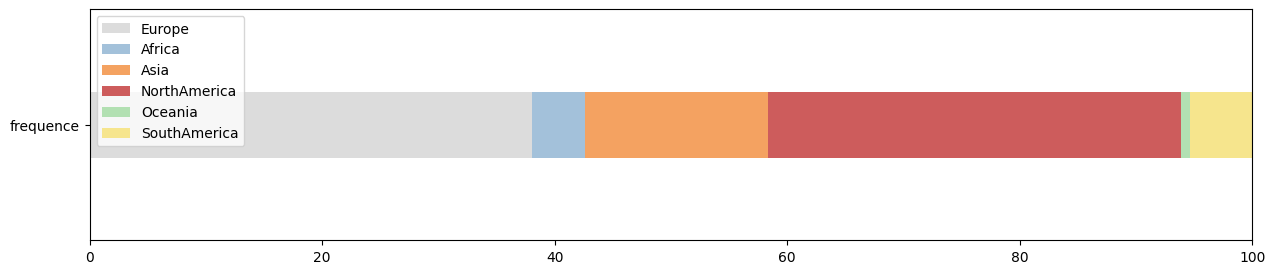

In [47]:

### Comparer avec l'ensemble de la période !
# Noter que la distribution  de la dernière tranche temporelle est quasiment la même pour l'ensemble de la période 
# du fait des effectifs très importants du 20e siècle, qui définissent la tendance générale

fig = ljt.plot(kind='barh', stacked=True, figsize=(15,3), color=col_palette_1, width=0.2, xlim=[0,100])

